# Triangle Prism Densities

An example application of the `circle_bundles` pipeline to a dataset where the underlying model is a non-orientable 3-manifold which admits a circle bundle structure over $\mathbb{RP}^{2}$ with non-trivial twisted Euler class. 

Also a demonstration of the bundle-coordinatization feature of `circle_bundles` which produces a topologically-faithful lower-dimensional representation of the data. 

We generate a dataset by applying random $SO(3)$ rotations to the vertices of a triangular prism embedded in the unit ball, then constructing 3D density functions on $\overline{\mathbb{B}}_{1}(0)$ from the rotated prisms which are Gaussian-distributed around their boundaries.  For analysis, we define an $\mathbb{RP}^{2}$-valued feature map which roughly captures the axis of symmetry of each density. One can show that the underlying bundle structure is non-orientable with twisted Euler number $\pm 3$.

We recover the characteristic classes, which determines the topology of the total space up to homeomorphism (in particular, it is a quotient of $SO(3)$). We then restrict to a subset of the data which projects to an 'equator' $\mathbb{RP}^{1}\subset\mathbb{RP}^{2}$ and verify that the restriction has the structure of a Klein bottle.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

import circle_bundles as cb

Start by generating a synthetic dataset of 3D densities represented as vectors of length $32^{3}$. Record the corresponding triangle meshes for visualization (represented as vectors in $\mathbb{R}^{18}$):

In [2]:
#Create the template triangle mesh
mesh, face_groups = cb.make_tri_prism(height=1, radius=1)

#Generate a random sample of SO(3) matrices
n_samples = 5000
rng = np.random.default_rng(0)
so3_data = cb.sample_so3(n_samples, rng=rng)[0]

#Apply rotations to the template mesh
mesh_data = cb.get_mesh_sample(mesh, so3_data)

#Generate 3D densities from the rotated meshes
grid_size = 32  #density resolution
sigma = 0.05  #density gaussian parameter

data = cb.make_rotated_density_dataset(
    mesh,
    so3_data,
    grid_size = grid_size,
    sigma = sigma,
)

#Create visualization functions for triangle meshes and 3D densities
vis_density = cb.make_density_visualizer(grid_size=grid_size)
vis_mesh = cb.make_tri_prism_visualizer(mesh, face_groups)

View a small sample of the dataset, represented by 2D projections of the 3D densities and also by the triangle meshes used to produce the densities.

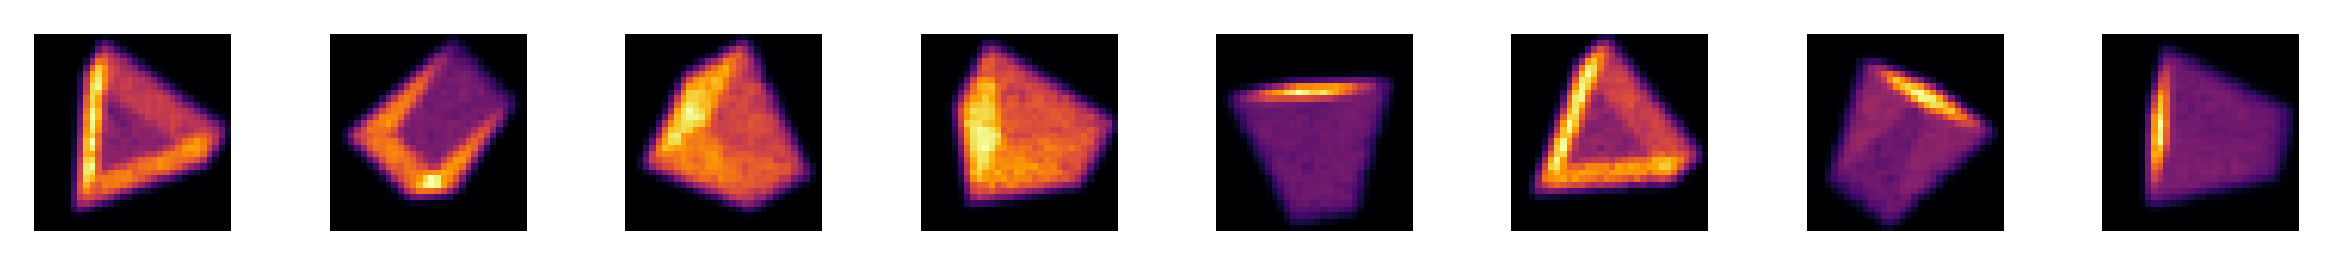

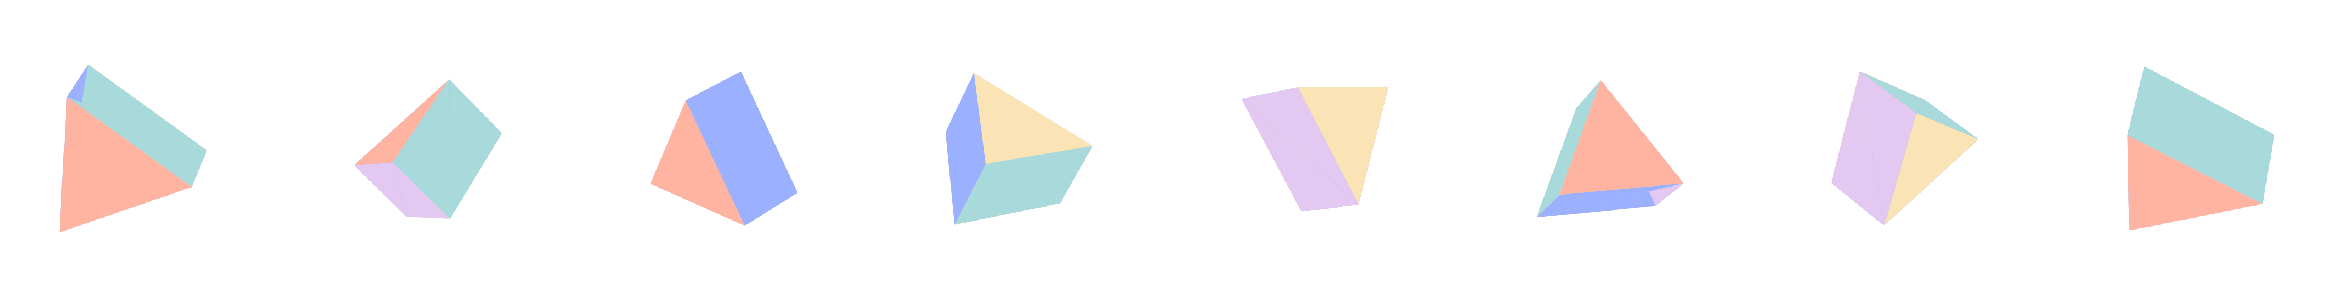

In [3]:
fig = cb.show_data_vis(
    data, 
    vis_density, 
    max_samples=8, 
    n_cols=8, 
    sampling_method="first")
plt.show()

fig = cb.show_data_vis(
    mesh_data, 
    vis_mesh, 
    max_samples=8, 
    n_cols=8, 
    sampling_method="first", 
    pad_frac=0.3)
plt.show()


$\textbf{Note:}$ 2D projections of the 3D densities are computed by summing intensities along the z-axis, shown here as perpendicular to the screen.  In general, reflecting a rotated prism mesh through the z-axis may produce a very different 3D density, but the 2D projections will appear the same.  On the other hand, two prism meshes which differ by a rotation in the symmetry group of the prism yield indistinguishable 3D densities -- this is a genuine symmetry of the dataset.  

For each 3D density, compute the principal component (up to sign in $\mathbb{RP}^{2}$) associated with the smallest eigenvalue -- for densities in the dataset, this axis is always clearly defined and coincides with the axis of rotational symmetry. Record the $\mathbb{RP}^{2}$ projections as unit vectors in the upper hemisphere of $\mathbb{S}^{2}$:

In [4]:
base_points = cb.get_density_axes(data)

Construct an open cover of $\mathbb{RP}^{2}$ using a collection of nearly equidistant landmark points (see reference section):

### Cover And Nerve Summary
- $n_\text{sets} = 60$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 60$
- $\#(\text{1-simplices}) = 177$
- $\#(\text{2-simplices}) = 118$
- *No recorded simplices in dimensions* $\ge 3$

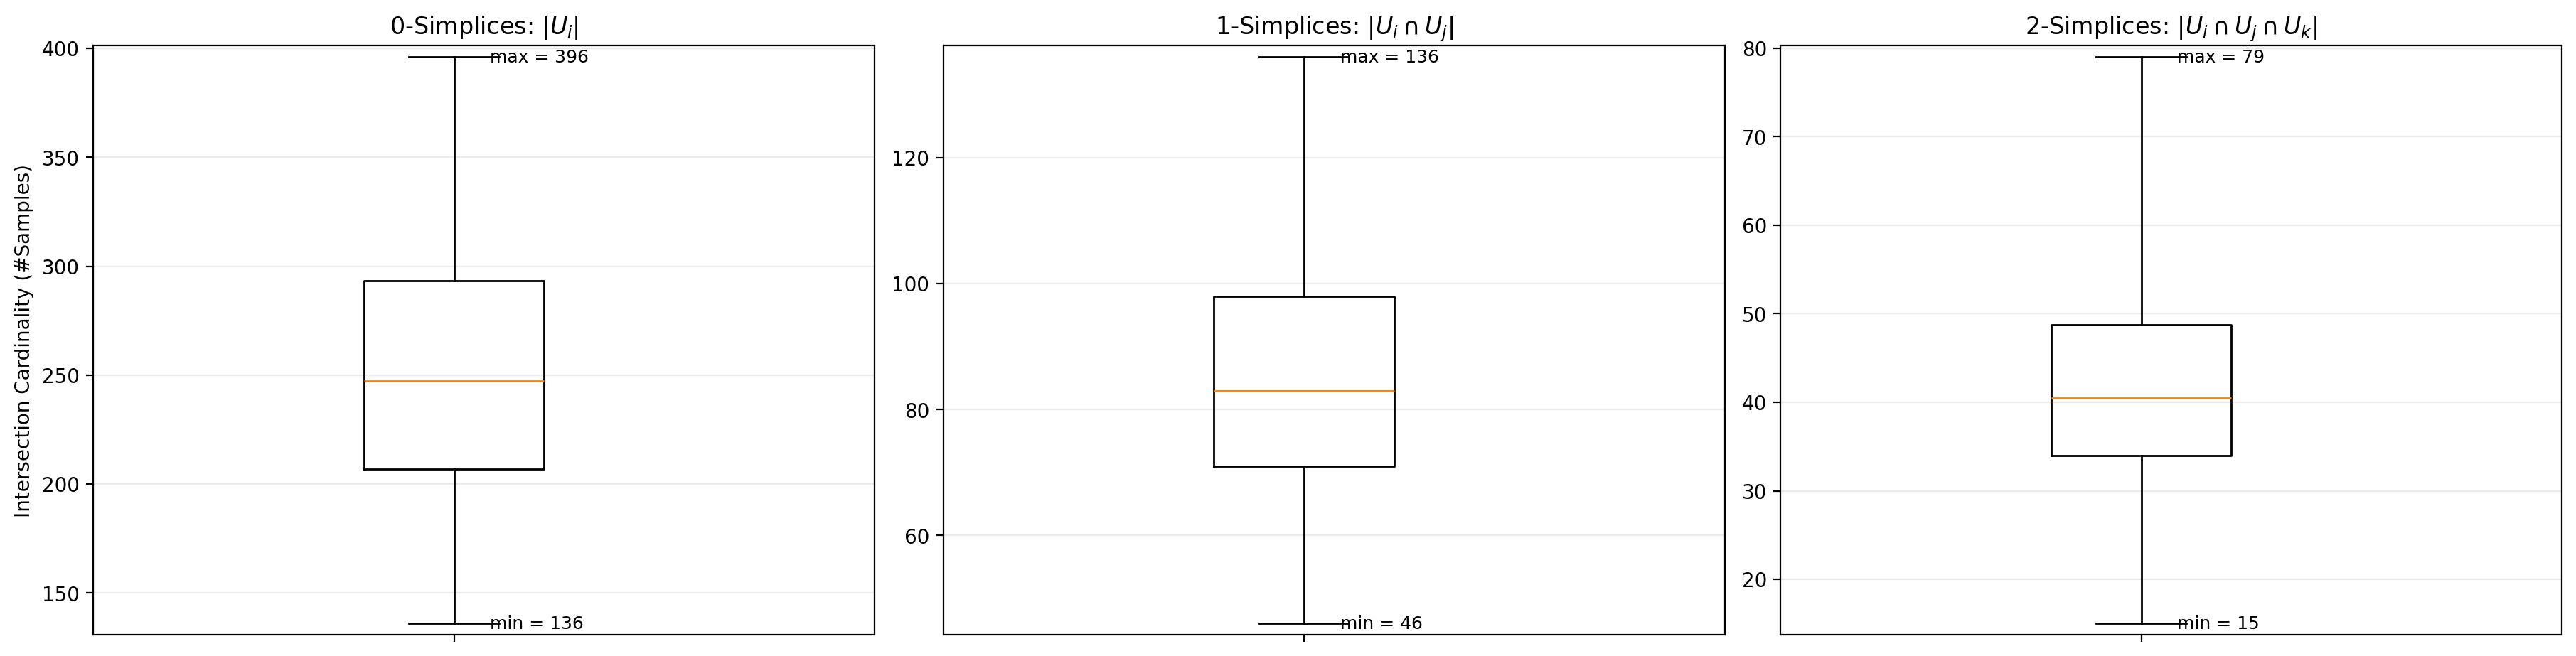

In [6]:
n_landmarks = 60
cover = cb.make_rp2_fibonacci_star_cover(base_points, n_pairs = n_landmarks)

summ = cover.summarize(plot = True)

Optionally run the cell below to view a Plotly visualization of the nerve of the open cover:

In [ ]:
fig = cover.show_nerve()

Compute a persistence diagram for the data in each set $\pi^{-1}(U_{j})$:

/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


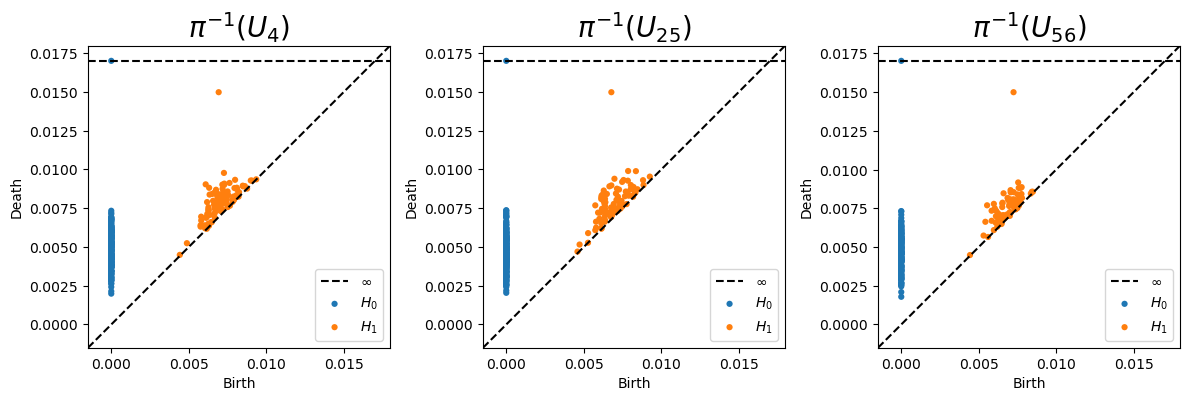

In [7]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    cover.U,
    to_view = [4,25,56], #Choose a few diagrams to compute 
                       #(or compute all by setting to None)
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Optionally run the cell below to show a visualization of a 'fat fiber' of the projection map:

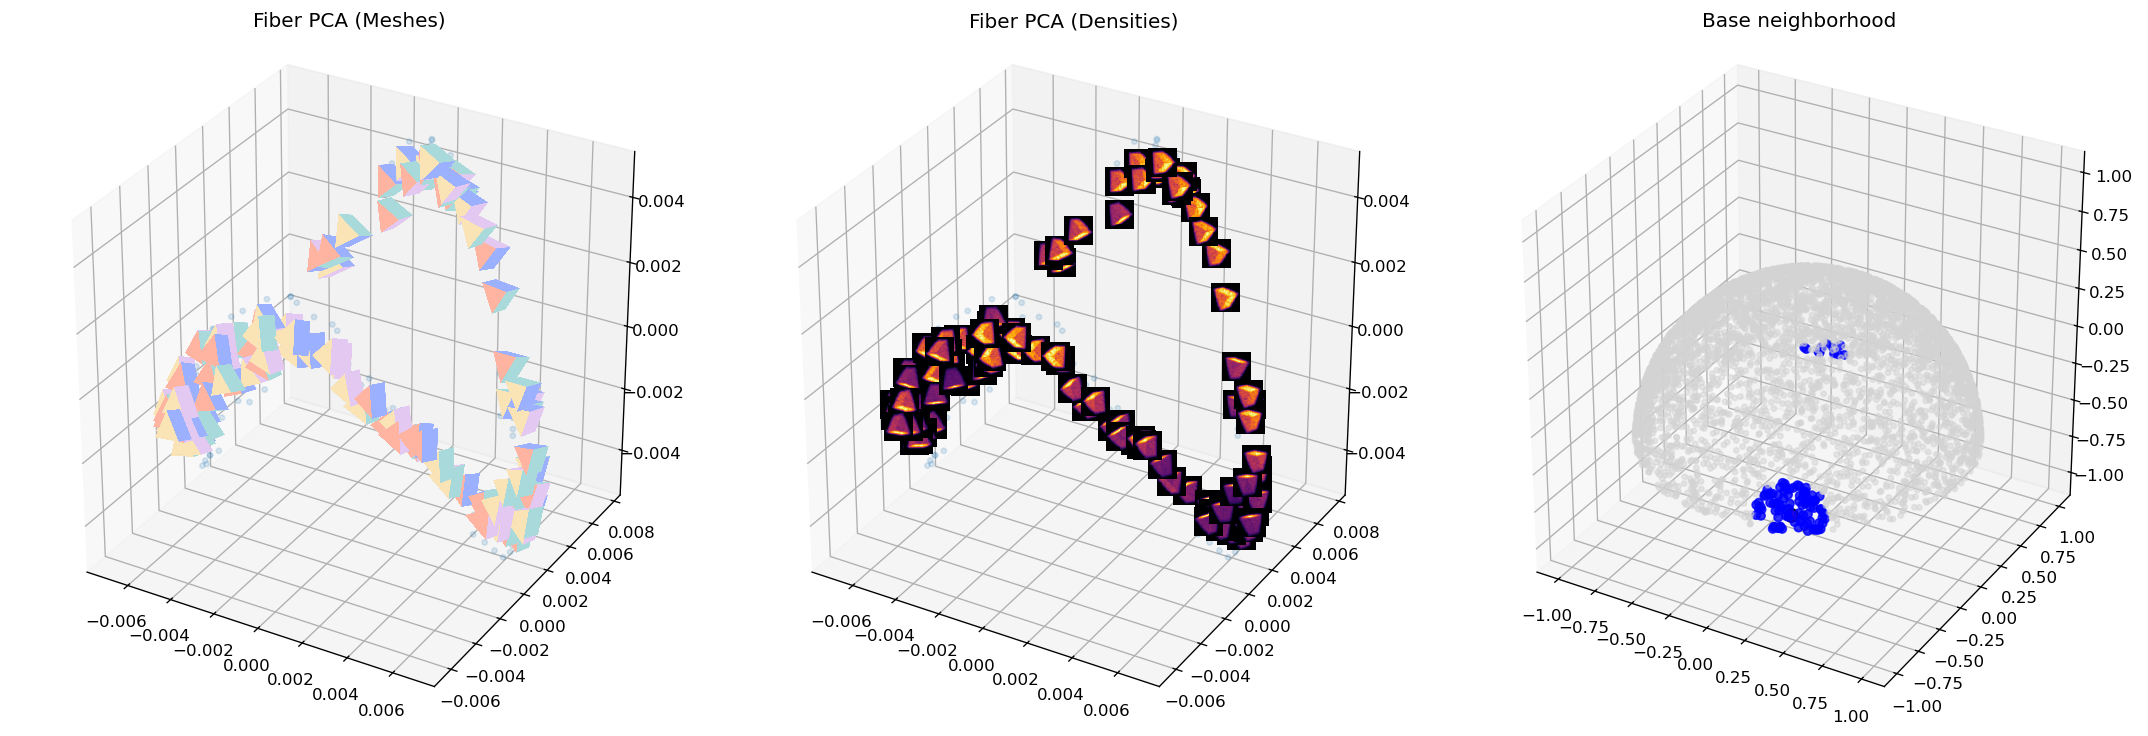

In [8]:
center_ind = 201
r = 0.2
dist_mat = cover.metric.pairwise(X=cover.base_points)
nearby_indices = np.where(dist_mat[center_ind] < r)[0]

fiber_data = data[nearby_indices]
vis_data = mesh_data[nearby_indices]


fig = plt.figure(figsize=(18, 6), dpi=120)
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

# PCA labeled with meshes
cb.fiber_vis(
    fiber_data,
    vis_mesh,
    vis_data=vis_data,
    max_images=200,
    zoom=0.08,
    ax=ax1,
    show=False,
)
ax1.set_title("Fiber PCA (Meshes)")

# PCA labeled with density projections
cb.fiber_vis(
    fiber_data,
    vis_func=vis_density,
    max_images=200,
    zoom=0.05,
    ax=ax2,
    show=False,
)
ax2.set_title("Fiber PCA (Densities)")

# Base visualization
cb.base_vis(
    cover.base_points,
    center_ind,
    r,
    dist_mat,
    ax=ax3,
    show=False,
)
ax3.set_title("Base neighborhood")

plt.tight_layout()
plt.show()


Construct local circular coordinates, then compute approximate transition matrices and characteristic clases:

In [12]:
bundle = cb.build_bundle(
    data,
    cover,
    show=True,                          
)


<IPython.core.display.Math object>

Show some correlations between local circular coordinates on overlaps

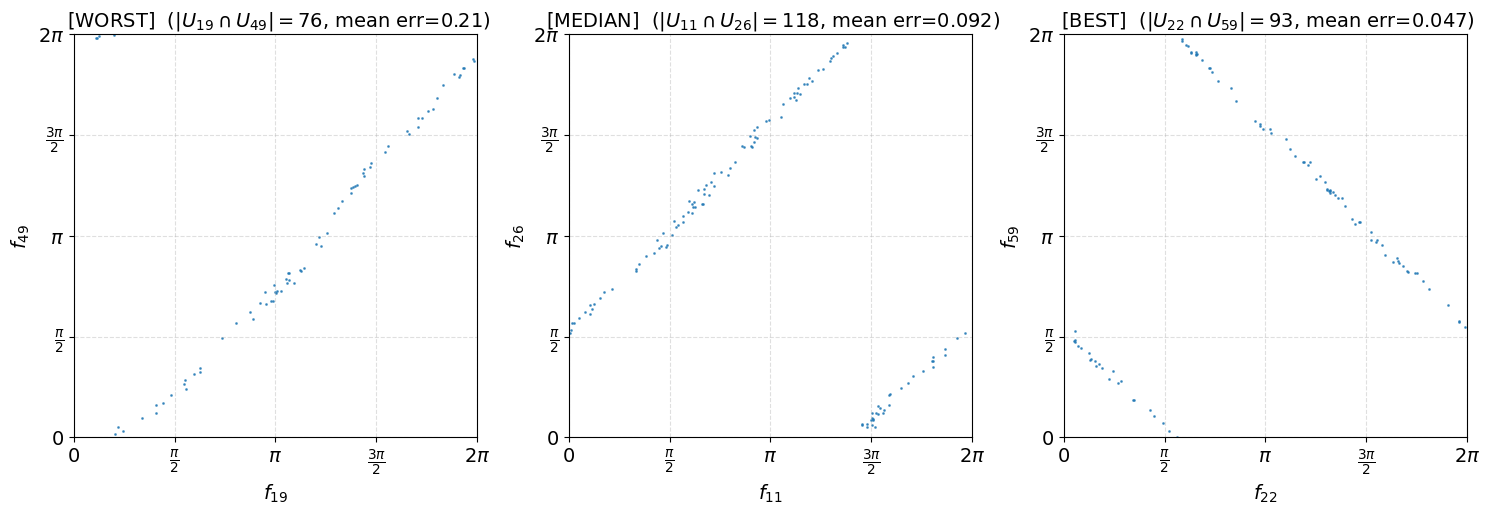

In [13]:
fig = bundle.compare_trivs()
plt.show()

Compute class persistence on the weights filtration of the nerve (see theory section for details):

In [14]:
pers = bundle.get_persistence(show = True)


<IPython.core.display.Math object>

Observe that the twisted Euler class becomes trivial as soon as a single edge is removed.  This is to be expected, since the resulting subcomplex deformation retracts onto its 1-skeleton.  On the other hand, the orientation class does not become trivial until many edges are removed. This is also reasonable, since one can show that the restriction of a non-orientable bundle over $\mathbb{RP}^{2}$ to an 'equator' $\mathbb{RP}^{1}$ is still non-orientable (hence non-trivial) -- see below. In any case, observe that the variation in weight across this large collection of edges is relatively small, suggesting that our model is likely reliable across the entire nerve. 

Now, to construct a lower-dimensional representation of the high-dimensional dataset, compute a classifying map to $Gr(2)$ representing the underlying circle bundle and compute the pullback of the canonical circle bundle $V(2)\times_{O(2)}\mathbb{S}^{1}$ (see theory section for details):  

In [15]:
pullback_results = bundle.get_pullback_data(
    subcomplex = 'full',
    base_weight=1.0,
    fiber_weight=1.0,
    packing = 'coloring2',
    show_summary = True,
)


<IPython.core.display.Math object>

Notice that the pullback data lives in the ambient space $\mathbb{RP}^{2}\times\mathbb{R}^{24}$.  Check that the base projections of the pullback data coincide with the projections of the original densities:

In [16]:
pullback_data = pullback_results.total_data
proj_map = pullback_results.base_proj_map
pullback_base_points = proj_map(pullback_data)

assert np.allclose(pullback_base_points, base_points)
print("Projections agree")

Projections agree


Construct the pullback bundle over $\mathbb{RP}^{2}$ and verify it has the same classification as the original dataset:



In [17]:
pb_bundle = cb.build_bundle(
    pullback_results.total_data,
    cover,
    show=True,
    total_metric = pullback_results.metric  #by default, we use the L2 product metric
)

<IPython.core.display.Math object>

Now, restrict the original bundle to the 'equator' $\mathbb{RP}^{1}\subset \mathbb{RP}^{2}$:

In [19]:
eps = 0.15  # thickness of equatorial band (in the chosen RP^2 embedding/coords)

# Points near the equator: last coordinate close to 0
eq_mask = np.abs(base_points[:, -1]) < eps

eq_data = bundle.data[eq_mask]
eq_mesh_data = mesh_data[eq_mask]

# Parametrize the equator by an angle in RP^1 (theta ~ theta + pi)
eq_base_angles = np.arctan2(base_points[eq_mask, 1], base_points[eq_mask, 0]) % np.pi

print(f"Equator band: {eq_data.shape[0]} / {bundle.data.shape[0]} samples (eps={eps}).")

Equator band: 692 / 5000 samples (eps=0.15).


Constuct an open cover of $\mathbb{RP}^{1}$ by metric balls around equally-spaced landmark points, then construct the restricted bundle object:

In [20]:
n_landmarks = 12
landmarks = np.linspace(0, np.pi, n_landmarks, endpoint=False)

overlap = 1.5
radius = overlap * np.pi / (2 * n_landmarks)

eq_cover = cb.MetricBallCover(
    eq_base_angles,
    landmarks,
    radius,
    metric=cb.RP1AngleMetric(),
)
eq_cover_data = eq_cover.build()

eq_bundle = cb.build_bundle(
    eq_data,
    eq_cover,
    show=True,
)

<IPython.core.display.Math object>

The characteristic classes confirm that the restricted dataset has the topology of a Klein bottle embedded in $\mathbb{R}^{32^{3}}$.

Compute a global 'coordinate system' for the restricted dataset after dropping the heaviest edge from the nerve of the cover of $\mathbb{RP}^{1}$:

In [21]:
eq_triv_result = eq_bundle.get_global_trivialization()

Show a visualization of the nerve of the cover of $\mathbb{RP}^{1}$ decorated with edge weights:

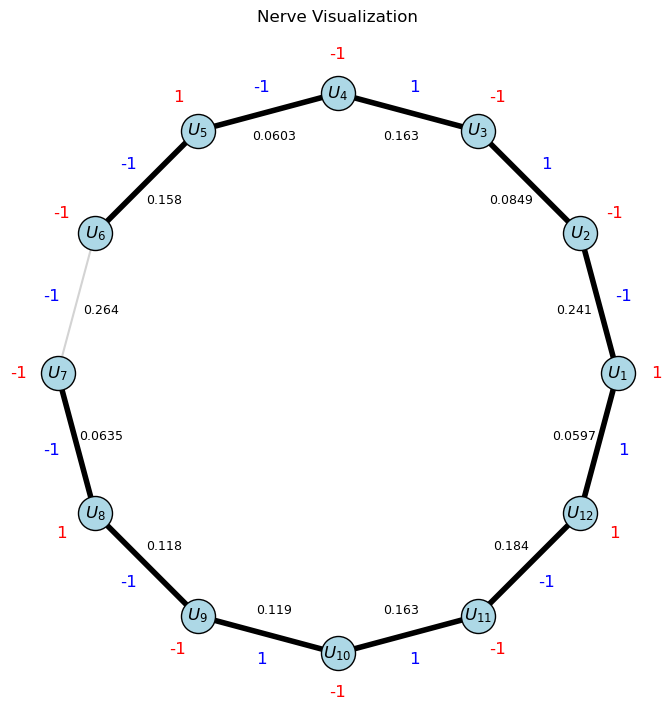

In [22]:
#Compute a potential for the restricted orientation class
eq_subcomplex = eq_bundle.get_max_trivial_subcomplex()
edges = eq_subcomplex.kept_edges
Omega = eq_bundle.classes.cocycle_used.restrict(edges)
phi_vec = Omega.orient_if_possible(edges)[2]
phi = {lmk: phi_vec[lmk] for lmk in range(len(eq_cover.landmarks))}
omega = eq_bundle.classes.omega_O1_used

fig = eq_bundle.show_circle_nerve(omega = omega, phi = phi)
plt.show()


The value of the orientation cocycle on each edge is shown in blue, and the removed edge is clearly indicated.  A potential for the cocycle after restriction is shown in red.  

Finally, show a visualization of the coordinatized densities, represented by both the corresponding triangle meshes and 2D projections of the densities themselves:

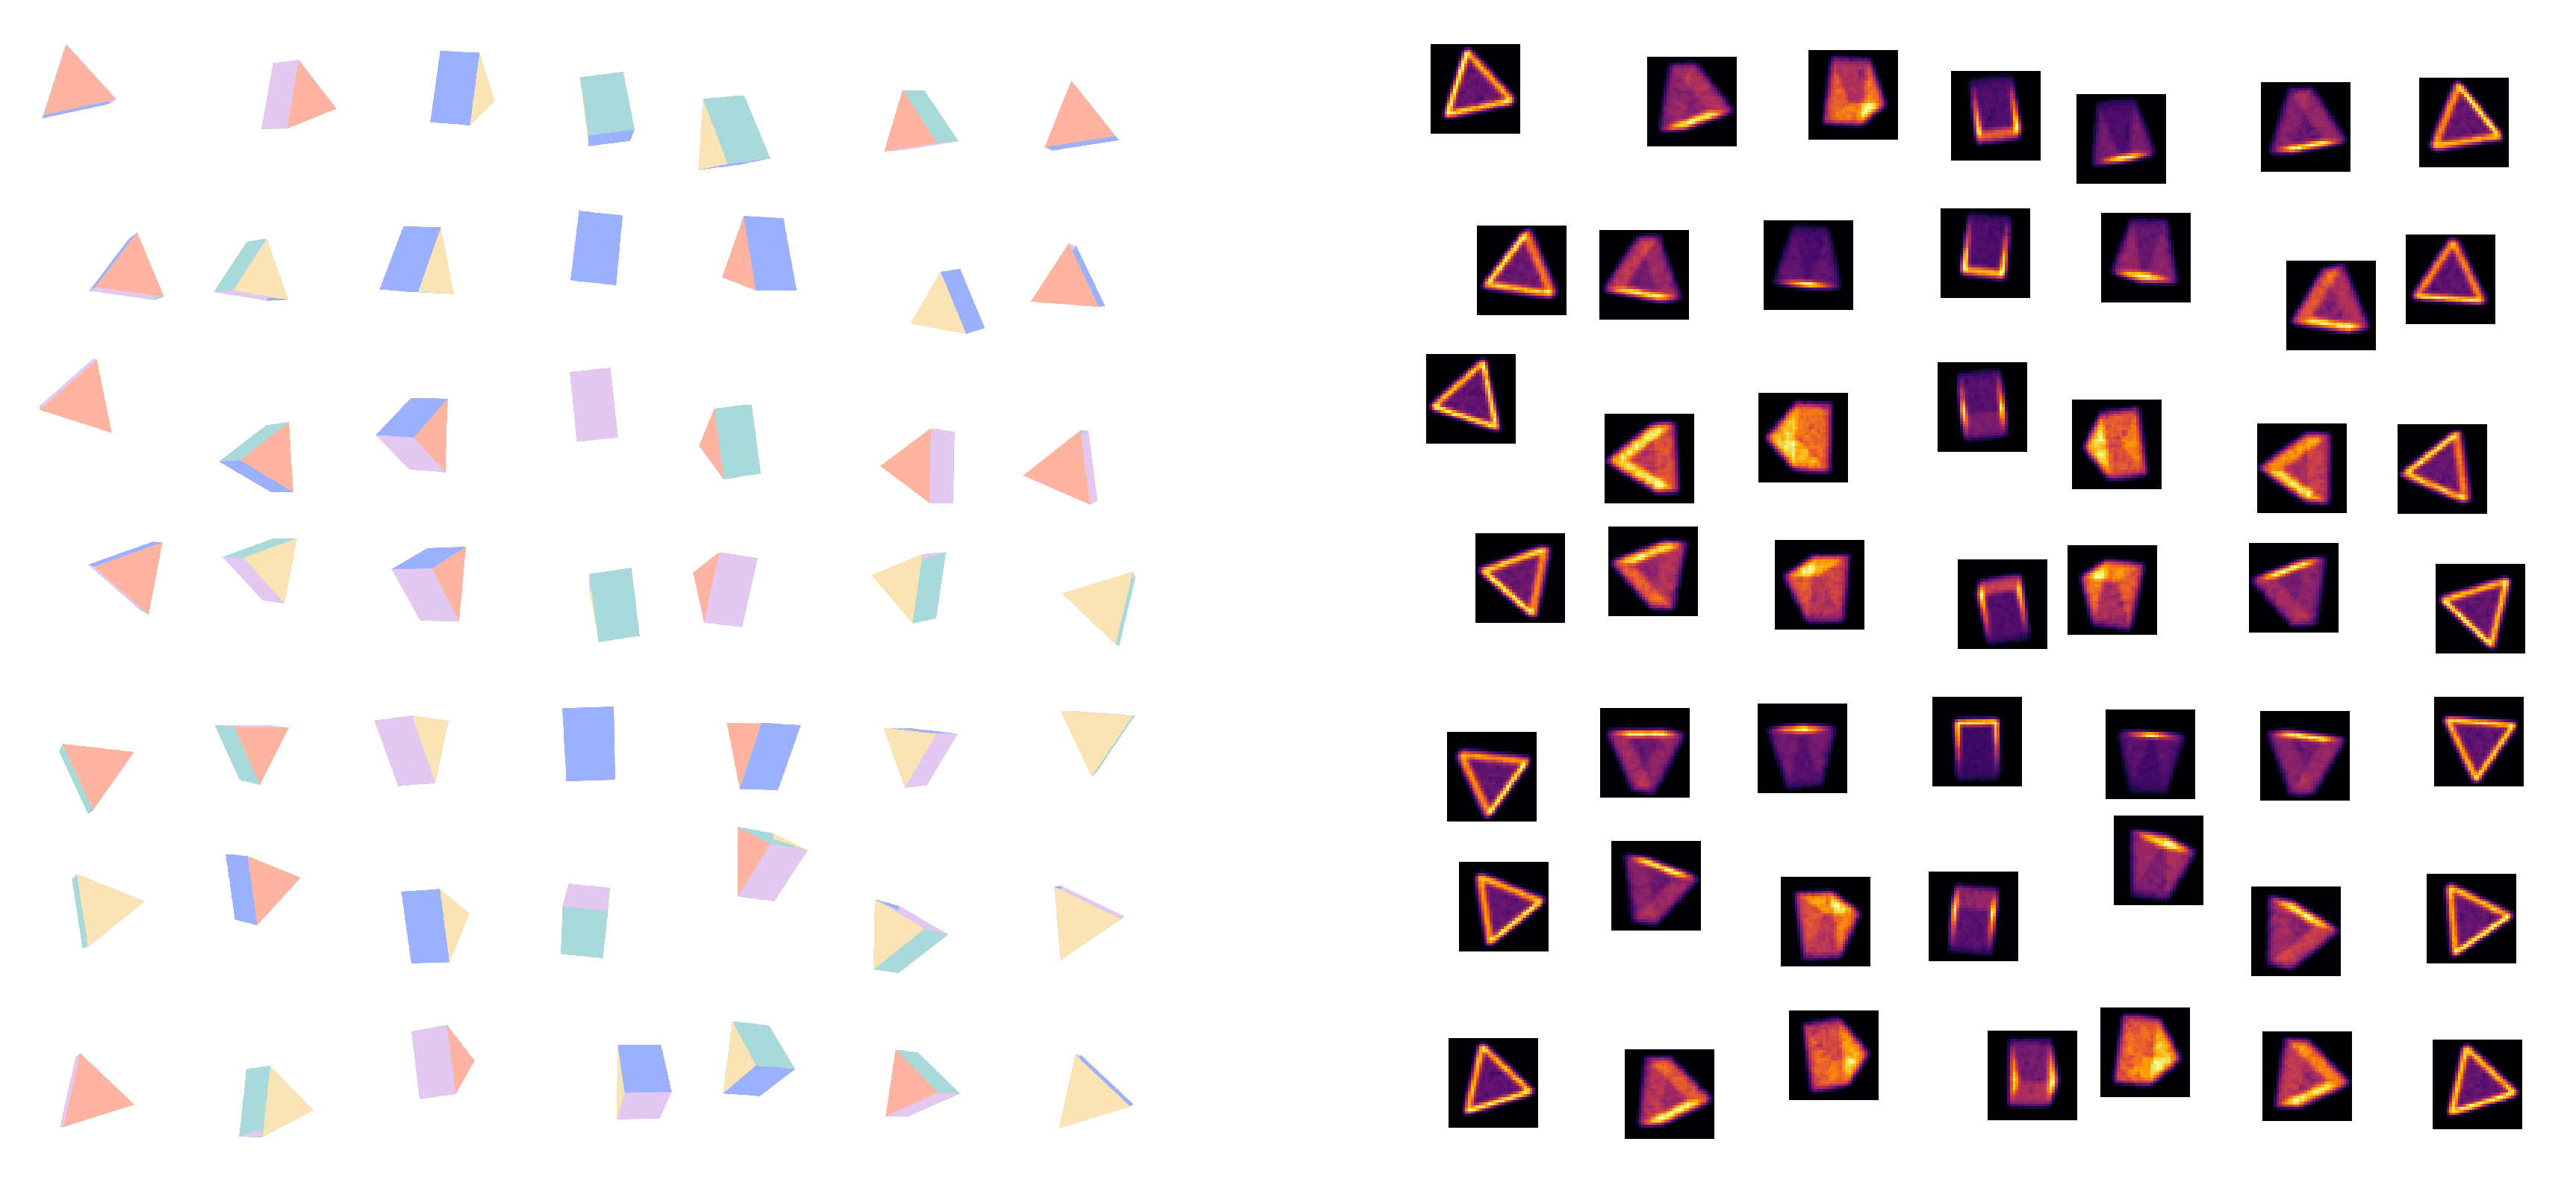

In [23]:
coords = np.column_stack([eq_base_angles, eq_triv_result.F])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), dpi=200)

cb.lattice_vis(
    eq_mesh_data,
    coords,
    vis_mesh,
    per_row=7,
    per_col=7,
    figsize=10,
    thumb_px=100,
    dpi=200,
    ax=ax1,
)

cb.lattice_vis(
    eq_data,
    coords,
    vis_density,
    per_row=7,
    per_col=7,
    figsize=10,
    thumb_px=120,
    dpi=200,
    ax=ax2,
)
plt.show()


Notice that base projection roughly corresponds to axis of symmetry, as expected.  Upon carefuly inspection, one can see that coordinatized densities in each column approximately traverse a 1/3 rotation about the axis of symmetry, but the direction of rotation abruptly changes from counter-clockwise to clockwise between columns 1 and 2. This reflects the fundamental non-orientability of the underlying circle bundle structure over $\mathbb{RP}^{1}$ (in particular, the underlying manifold is a Klein bottle). 